# Population Map by Departments

In [3]:
from pynsee.geodata import *
from pynsee.localdata import *

import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

# Subscribe to api.insee.fr and get your credentials!
# Save your credentials with init_conn function :
# from pynsee.utils.init_conn import init_conn
# init_conn(insee_key="my_insee_key", insee_secret="my_insee_secret")

# Beware : any change to the keys should be tested after having cleared the cache
# Please do : from pynsee.utils import clear_all_cache; clear_all_cache()"

dataset_list = get_dataset_list()

id = get_series_list("TCRED-ESTIMATIONS-POPULATION") 

id = id.loc[(id.AGE == "00-") &
            (id.SEXE == "0") &
            (id.REF_AREA.str.match("^D"))]

data = get_series(id.IDBANK, lastNObservations=1)
data = data[['REF_AREA', 'OBS_VALUE']]


Getting datasets list: 100%|██████████| 197/197 [00:00<00:00, 1315.22it/s]


TCRED-ESTIMATIONS-POPULATION : metadata update triggered because it is not found locally


1/1 - Getting series: 100%|██████████| 101/101 [00:00<00:00, 353.53it/s]



Data has been cached



In [10]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

Previously saved data used
/home/jovyan/.cache/insee/pynsee/a28d68dc88fcd55fe62626ea25a1760a.csv
Set update=True to get the most up-to-date data


In [63]:
geodata_list.head()

,Topic,DataFormat,ApiVersion,Identifier,Abstract,Title,DefaultCRS
0,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement.t...,urn:ogc:def:crs:EPSG::4326
1,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,urn:ogc:def:crs:EPSG::4326
2,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:canton,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:canton.title,urn:ogc:def:crs:EPSG::4326
3,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,urn:ogc:def:crs:EPSG::4326
4,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune....,urn:ogc:def:crs:EPSG::4326


In [20]:
# remove overseas departments
depfrm = dep[~dep['insee_dep'].isin(['971', '972', '973', '974', '976'])]

In [62]:
map = gpd.GeoDataFrame(depfrm).set_crs("EPSG:4326")
map['REF_AREA'] = 'D' + map['insee_dep']

map = map.to_crs(epsg=3035)
map["area"] = map['geometry'].area / 10**6
map = map.to_crs(epsg=4326)

map = map.merge(data, how = 'left', on = 'REF_AREA')
map['density'] = map['OBS_VALUE'] / map["area"]

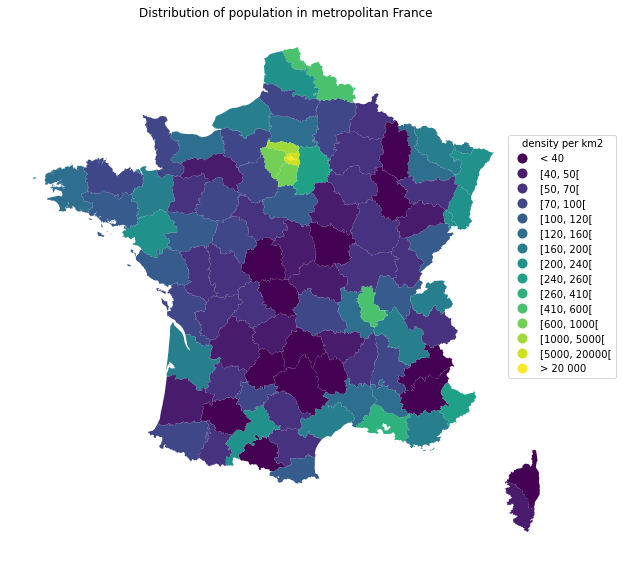

In [61]:

map.loc[map.density < 40, 'range'] = "< 40"
map.loc[map.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 50, 70, 100, 120, 160, 200, 240, 260, 410, 600, 1000, 5000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min = density_ranges[i]
    max = density_ranges[i+1]
    range_string = "[{}, {}[".format(min, max)
    map.loc[(map.density >= min) & (map.density < max), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

map['range'] = map['range'].astype( CategoricalDtype(categories=list_ranges, ordered=True))

fig, ax = plt.subplots(1,1,figsize=[10,10])
map.plot(column='range', cmap=cm.viridis, 
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in metropolitan France')
plt.show()